In [97]:
import os
import pickle
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

from sklearn.metrics import confusion_matrix, f1_score 

In [2]:
# this function only describes how much a singular value in al ist stands out.
# if all values in the lsit are high or low this is 1
# the smaller the proportiopn of number of disimilar vlaues are to other more similar values the lower this number
# the larger the gap between the dissimilar numbers and the simialr number the smaller this number
# only able to interpret probabilities or values between 0 and 1
# this function outputs an estimate an inverse of the classification confidence based on the probabilities of all the classes.
# the wedge threshold splits the data on a threshold with a magnitude of a positive int to force a ledge/peak in the data
def unknown_prob_calc(probs, wedge_threshold=0.85, wedge_magnitude=1, wedge='strict'):
    if wedge =='strict':
        increase_var = (1/(wedge_magnitude))
        decrease_var = (wedge_magnitude)
    if wedge =='dynamic': # this allows pointsthat are furhter from the threshold ot be moved less and points clsoer to be moved more
        increase_var = (1/(wedge_magnitude*((1-np.abs(probs-wedge_threshold)))))
        decrease_var = (wedge_magnitude*((1-np.abs(probs-wedge_threshold))))
    # else:
    #     print("Error: use 'strict' (default) or 'dynamic' as options for the wedge parameter!")
    probs = np.where(probs>=wedge_threshold , probs**increase_var, probs)
    probs = np.where(probs<=wedge_threshold , probs**decrease_var, probs)
    diff_matrix = np.abs(probs[:, np.newaxis] - probs)
    diff_matrix_sum = np.sum(diff_matrix)
    probs_sum = np.sum(probs)
    class_val = (diff_matrix_sum/probs_sum)
    max_class_val = ((len(probs)-1)*2)
    kown_prob = class_val/max_class_val
    unknown_prob = 1-kown_prob
    return(unknown_prob)

In [3]:
species_lst = ['Coccotypes_dactyliperda', 'Hylesinus_varius', 'Monarthrum_fasciatum',
                'Phloeosinus_dentatus', 'Pityophthorus_juglandis', 'Platypus_cylindrus',
                'Pycnarthrum_hispidium', 'Scolotodes_schwarzi', 'Xyleborinus_saxesenii',
                'Xyleborus_affinis', 'Xylosandrus_compactus',
                'Xylosandrus_crassiusculus']

# get working directory
pwd = os.getcwd()
raw = r"E:\GIT_REPOS\Beetle_classifier\Data\raw\\"
data_dist = pd.read_csv(raw+"Data_distribution.csv", index_col="Species")
data_dist

,test,train,train_1,train_2,train_3,train_4,train_5,valid,valid_1,valid_2,valid_3,valid_4,valid_5
Species,,,,,,,,,,,,,
Coccotypes_dactyliperda,615,3342,3280,3458,3454,3579,3641,1011,1073,895,899,774,712
Xyleborinus_saxesenii,380,1542,1625,1663,1833,1855,1716,631,548,510,340,318,457
Pityophthorus_juglandis,680,3194,3086,3107,3219,3203,3341,795,903,882,770,786,648
Monarthrum_fasciatum,133,846,827,818,828,976,1011,269,288,297,287,139,104
Pycnarthrum_hispidium,208,1192,1146,1123,1197,1337,1413,362,408,431,357,217,141
Xyleborus_affinis,456,3127,3191,3214,3121,3388,3654,1015,951,928,1021,754,488
Scolotodes_schwarzi,467,1678,1672,1601,1664,1746,1861,458,464,535,472,390,275
Xylosandrus_crassiusculus,326,2443,2848,2828,2552,2334,2278,767,362,382,658,876,932
Hylesinus_varius,216,1312,1309,1413,1396,1369,1413,413,416,312,329,356,312


In [4]:
# import validation data
with open('valid_dict_species_unknown.pkl', 'rb') as f:
    valid_dict_species_unknown = pickle.load(f)
    
# import testing data
with open('test_dict_species_unknown.pkl', 'rb') as f:
    test_dict_species_unknown = pickle.load(f)

In [24]:
# function to turn a threshold into ROC curve
def roc_calc(threshold_data_df, true_col, method = "threshold", wedge_magnitude = 1, wedge='strict'):
    threshold_lst = sorted(set(list(np.arange(0, 1, 0.1)) + [1] + np.array(threshold_data_df.max(axis=1).round(1).drop_duplicates()).flatten().tolist()))
    tpr_lst = []
    fpr_lst = []
    roc_result = pd.DataFrame()
    for threshold in threshold_lst:
        data_df = threshold_data_df.copy()
        # processing
        if method == "threshold":
            data_df['Unknown'] = threshold
            data_df['pred'] = data_df.idxmax(axis=1)
        else:
            data_df['Unknown'] = data_df.apply(unknown_prob_calc, axis=1, args=(threshold, wedge_magnitude, wedge))
            data_df['pred'] = data_df.idxmax(axis=1)


        data_df.loc[data_df['pred'] != 'Unknown', 'pred'] = "Known"
        data_df['true'] = true_col

        tn, fp, fn, tp = confusion_matrix(y_true=data_df['true'], y_pred=data_df['pred']).ravel()
        tpr = tp/(tp + fn)
        fpr = fp/(fp + tn)
        tpr_lst.append(tpr)
        fpr_lst.append(fpr)
    roc_result['tpr'] = tpr_lst
    roc_result['fpr'] = fpr_lst
    roc_result['threshold'] = threshold_lst
    return(roc_result)

In [18]:
def find_best_threshold(tpr, fpr, thresholds):
    """
    Find the best threshold value from a list of TPR and FPR values.
    Returns the best threshold value based on the Youden’s J statistic.
    """
    j_scores = tpr - fpr
    best_index = np.argmax(j_scores)
    best_threshold = thresholds[best_index]
    return best_threshold

# Validation

In [6]:
# import validation data
with open('valid_dict_species_unknown.pkl', 'rb') as f:
    valid_dict_species_unknown = pickle.load(f)

# validation calculation
own_dynamic_valid_df_lst = []
own_strict_valid_df_lst = []
threshold_valid_df_lst = []
for fold in range(1,6):
    og_data_df = valid_dict_species_unknown['fold_'+str(fold)]
    own_dynamic_valid_df = roc_calc(threshold_data_df = og_data_df.iloc[:,2:], true_col = og_data_df['true'],  method = "own", wedge_magnitude = 1, wedge='dynamic')
    own_dynamic_valid_df_lst.append(own_dynamic_valid_df)
    
    threshold_valid_df = roc_calc(threshold_data_df = og_data_df.iloc[:,2:], true_col = og_data_df['true'],  method = "threshold")
    threshold_valid_df_lst.append(threshold_valid_df)
    
# save dict as pickle file        
with open('own_dynamic_valid_df_lst.pkl', 'wb') as f:
    pickle.dump(own_dynamic_valid_df_lst, f)
    
# save dict as pickle file        
with open('threshold_valid_df_lst.pkl', 'wb') as f:
    pickle.dump(threshold_valid_df_lst, f)

### Dynamic

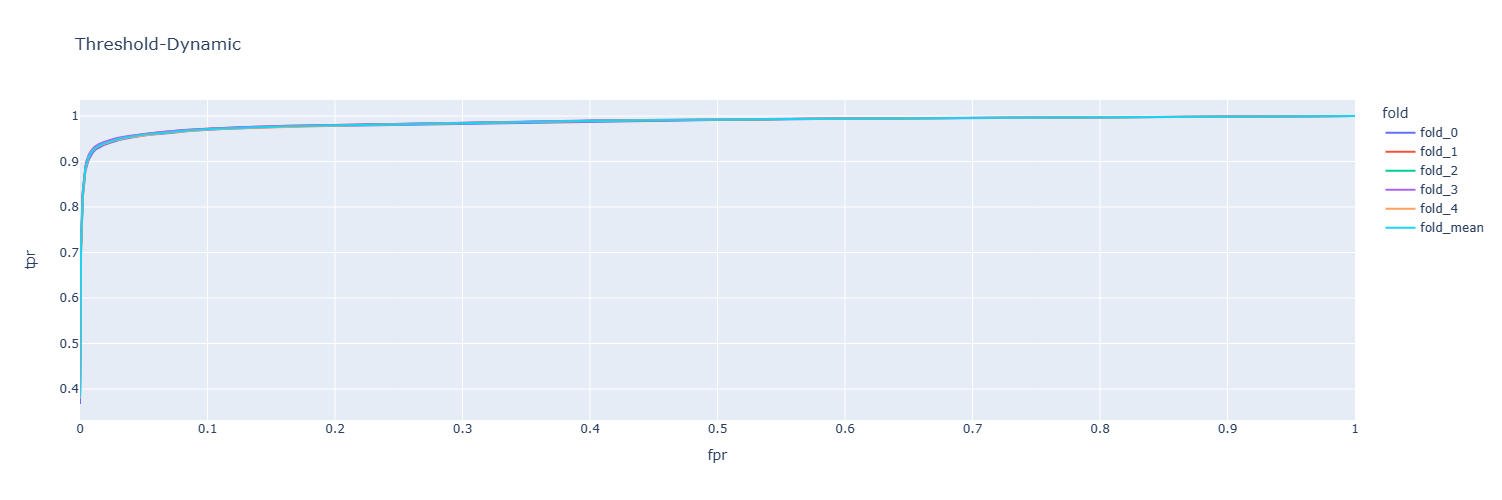

Best Mean Threshold:  0.78
Best Mean F1-Score:  0.06960761671718665


In [98]:
# import validation data
with open('valid_dict_species_unknown.pkl', 'rb') as f:
    valid_dict_species_unknown = pickle.load(f)

# open data
with open('own_dynamic_valid_df_lst.pkl', 'rb') as f:
    own_dynamic_valid_df_lst = pickle.load(f)

df_lst = own_dynamic_valid_df_lst # cahnge data source here

best_threshold_lst = []
avg_mean_df = sum(df_lst)/len(df_lst)
avg_mean_df['fold'] = 'fold_mean'
for i in range(len(df_lst)):
    df_lst[i]['fold'] = "fold_"+str(i)
    # get best threshold
    best_theshold = find_best_threshold(tpr=df_lst[i]['tpr'], fpr=df_lst[i]['fpr'] , thresholds=df_lst[i]['threshold'])
    best_threshold_lst.append(best_theshold)
joined_data_df = pd.concat(df_lst+[avg_mean_df])
mean_best_threshold = np.mean(best_threshold_lst).round(2)

# plot 
fig = px.line(joined_data_df, 
              x="fpr", 
              y="tpr", 
              color='fold',
              hover_data=['threshold'], 
              height=500, 
              width=500,
              title='Threshold-Dynamic')
fig.show()

f1_score_lst = []
for fold in range(1,6):
    og_data_df = valid_dict_species_unknown['fold_'+str(fold)]
    og_data_df['Unknown'] = og_data_df.iloc[:,2:].apply(unknown_prob_calc, axis=1, args=(mean_best_threshold, 1, 'dynamic'))
    og_data_df['pred'] = og_data_df.iloc[:,2:].idxmax(axis=1)
    f1_score_val = f1_score(y_true=og_data_df['true'], y_pred=og_data_df['pred'], average='weighted')
    f1_score_lst.append(f1_score_val)
    
print("Best Mean Threshold: ", mean_best_threshold)
print("Best Mean F1-Score: ", np.mean(f1_score_lst))

### Basic

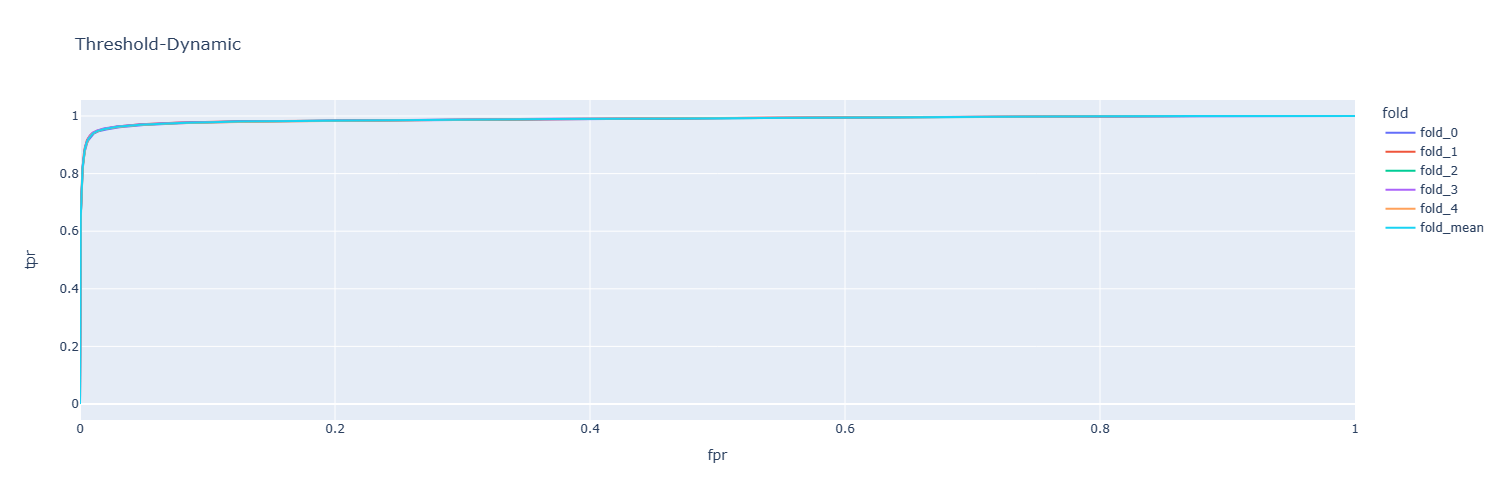

In [ ]:
# import validation data
with open('valid_dict_species_unknown.pkl', 'rb') as f:
    valid_dict_species_unknown = pickle.load(f)

# open data
with open('threshold_valid_df_lst.pkl', 'rb') as f:
    threshold_valid_df_lst = pickle.load(f)

df_lst = threshold_valid_df_lst # cahnge data source here

best_threshold_lst = []
avg_mean_df = sum(df_lst)/len(df_lst)
avg_mean_df['fold'] = 'fold_mean'
for i in range(len(df_lst)):
    df_lst[i]['fold'] = "fold_"+str(i)
    # get best threshold
    best_theshold = find_best_threshold(tpr=df_lst[i]['tpr'], fpr=df_lst[i]['fpr'] , thresholds=df_lst[i]['threshold'])
    best_threshold_lst.append(best_theshold)
joined_data_df = pd.concat(df_lst+[avg_mean_df])
mean_best_threshold = np.mean(best_threshold_lst).round(2)

# plot 
fig = px.line(joined_data_df, 
              x="fpr", 
              y="tpr", 
              color='fold',
              hover_data=['threshold'], 
              height=500, 
              width=500,
              title='Threshold-Dynamic')
fig.show()

f1_score_lst = []
for fold in range(1,6):
    og_data_df = valid_dict_species_unknown['fold_'+str(fold)]
    og_data_df['Unknown'] = mean_best_threshold
    og_data_df['pred'] = og_data_df.iloc[:,2:].idxmax(axis=1)
    f1_score_val = f1_score(y_true=og_data_df['true'], y_pred=og_data_df['pred'], average='weighted')
    f1_score_lst.append(f1_score_val)
    
print("Best Mean Threshold: ", mean_best_threshold)
print("Best Mean F1-Score: ", np.mean(f1_score_lst))

# Test

In [ ]:
# import validation data
with open('test_dict_species_unknown.pkl', 'rb') as f:
    test_dict_species_unknown = pickle.load(f)

# testing calculation
own_dynamic_test_df_lst = []
own_strict_test_df_lst = []
threshold_test_df_lst = []
for fold in range(1,6):
    og_data_df = test_dict_species_unknown['fold_'+str(fold)]
    own_dynamic_test_df = roc_calc(threshold_data_df = og_data_df.iloc[:,2:], true_col = og_data_df['true'],  method = "own", wedge_magnitude = 1, wedge='dynamic')
    own_dynamic_test_df_lst.append(own_dynamic_test_df)
    
    threshold_test_df = roc_calc(threshold_data_df = og_data_df.iloc[:,2:], true_col = og_data_df['true'],  method = "threshold")
    threshold_test_df_lst.append(threshold_test_df)
    
# save dict as pickle file        
with open('own_dynamic_test_df_lst.pkl', 'wb') as f:
    pickle.dump(own_dynamic_test_df_lst, f)
    
# save dict as pickle file        
with open('threshold_test_df_lst.pkl', 'wb') as f:
    pickle.dump(threshold_test_df_lst, f)

### Dynamic

In [ ]:
# import testation data
with open('test_dict_species_unknown.pkl', 'rb') as f:
    test_dict_species_unknown = pickle.load(f)

# open data
with open('own_dynamic_test_df_lst.pkl', 'rb') as f:
    own_dynamic_test_df_lst = pickle.load(f)

df_lst = own_dynamic_test_df_lst # cahnge data source here

best_threshold_lst = []
avg_mean_df = sum(df_lst)/len(df_lst)
avg_mean_df['fold'] = 'fold_mean'
for i in range(len(df_lst)):
    df_lst[i]['fold'] = "fold_"+str(i)
    # get best threshold
    best_theshold = find_best_threshold(tpr=df_lst[i]['tpr'], fpr=df_lst[i]['fpr'] , thresholds=df_lst[i]['threshold'])
    best_threshold_lst.append(best_theshold)
joined_data_df = pd.concat(df_lst+[avg_mean_df])
mean_best_threshold = np.mean(best_threshold_lst).round(2)

# plot 
fig = px.line(joined_data_df, 
              x="fpr", 
              y="tpr", 
              color='fold',
              hover_data=['threshold'], 
              height=500, 
              width=500,
              title='Threshold-Dynamic')
fig.show()

f1_score_lst = []
for fold in range(1,6):
    og_data_df = test_dict_species_unknown['fold_'+str(fold)]
    og_data_df['Unknown'] = og_data_df.iloc[:,2:].apply(unknown_prob_calc, axis=1, args=(mean_best_threshold, 1, 'dynamic'))
    og_data_df['pred'] = og_data_df.iloc[:,2:].idxmax(axis=1)
    f1_score_val = f1_score(y_true=og_data_df['true'], y_pred=og_data_df['pred'], average='weighted')
    f1_score_lst.append(f1_score_val)
    
print("Best Mean Threshold: ", mean_best_threshold)
print("Best Mean F1-Score: ", np.mean(f1_score_lst))

### Basic

In [ ]:
# import testation data
with open('test_dict_species_unknown.pkl', 'rb') as f:
    test_dict_species_unknown = pickle.load(f)

# open data
with open('threshold_test_df_lst.pkl', 'rb') as f:
    threshold_test_df_lst = pickle.load(f)

df_lst = threshold_test_df_lst # cahnge data source here

best_threshold_lst = []
avg_mean_df = sum(df_lst)/len(df_lst)
avg_mean_df['fold'] = 'fold_mean'
for i in range(len(df_lst)):
    df_lst[i]['fold'] = "fold_"+str(i)
    # get best threshold
    best_theshold = find_best_threshold(tpr=df_lst[i]['tpr'], fpr=df_lst[i]['fpr'] , thresholds=df_lst[i]['threshold'])
    best_threshold_lst.append(best_theshold)
joined_data_df = pd.concat(df_lst+[avg_mean_df])
mean_best_threshold = np.mean(best_threshold_lst).round(2)

# plot 
fig = px.line(joined_data_df, 
              x="fpr", 
              y="tpr", 
              color='fold',
              hover_data=['threshold'], 
              height=500, 
              width=500,
              title='Threshold-Dynamic')
fig.show()

f1_score_lst = []
for fold in range(1,6):
    og_data_df = test_dict_species_unknown['fold_'+str(fold)]
    og_data_df['Unknown'] = mean_best_threshold
    og_data_df['pred'] = og_data_df.iloc[:,2:].idxmax(axis=1)
    f1_score_val = f1_score(y_true=og_data_df['true'], y_pred=og_data_df['pred'], average='weighted')
    f1_score_lst.append(f1_score_val)
    
print("Best Mean Threshold: ", mean_best_threshold)
print("Best Mean F1-Score: ", np.mean(f1_score_lst))